<a href="https://colab.research.google.com/github/Joshua250304/Cat-Dog-Image-Classifier/blob/main/fcc_cat_dog_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [22]:
# Get project files
!apt-get update -qq && apt-get install -y -qq wget unzip
!rm -rf cats_and_dogs.zip && rm -rf cats_and_dogs
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
!ls -lah
!unzip -o cats_and_dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_do

In [23]:
PATH = 'cats_and_dogs'

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
train_dir      = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir       = os.path.join(PATH, 'test')

# -1 because of DS_Store
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])-1
total_val   = sum([len(files) for r, d, files in os.walk(validation_dir)])-1
total_test  = len(os.listdir(test_dir))-1

print('Train:', total_train)
print('Validation:', total_val)
print('Test:', total_test)

Train: 2000
Validation: 1000
Test: 50


In [24]:
# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [25]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
                                            directory=train_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=batch_size,
                                            class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
                                            directory=validation_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=batch_size,
                                            class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
                                            directory=test_dir,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            class_mode='binary',
                                            batch_size=batch_size,
                                            classes=['.'],
                                            shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


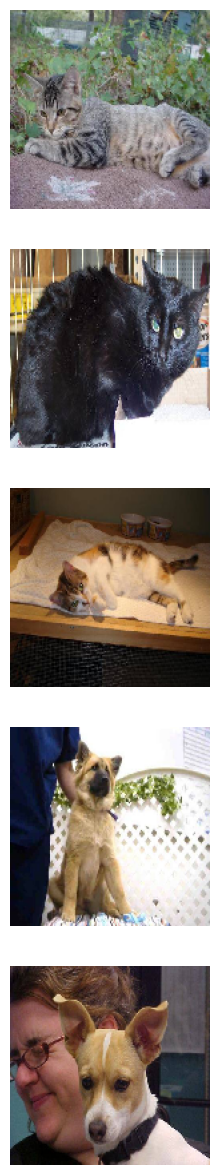

In [26]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [27]:
train_image_generator = ImageDataGenerator(rotation_range=20,
                                            shear_range=0.15,
                                            fill_mode='nearest',
                                            zoom_range=0.15,
                                            horizontal_flip=True,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            rescale=1./255
                                           )

Found 2000 images belonging to 2 classes.


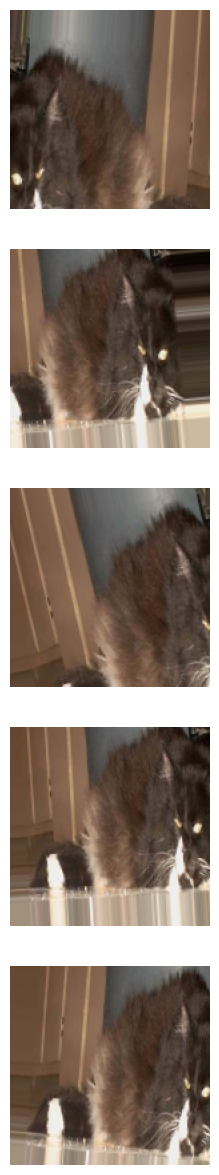

In [28]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [29]:
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2)
])


model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,678,178 (10.22 MB)

 Trainable params: 2,678,178 (10.22 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
steps_per_epoch=math.ceil(train_data_gen.n / train_data_gen.batch_size)
validation_steps=math.ceil(val_data_gen.n / val_data_gen.batch_size)


history = model.fit(train_data_gen,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_data_gen,
                    validation_steps=validation_steps,
                    )

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 919ms/step - accuracy: 0.5212 - loss: 0.6903 - val_accuracy: 0.5320 - val_loss: 0.6780
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 856ms/step - accuracy: 0.5589 - loss: 0.6789 - val_accuracy: 0.5500 - val_loss: 0.6666
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 877ms/step - accuracy: 0.5827 - loss: 0.6670 - val_accuracy: 0.6750 - val_loss: 0.6165
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 871ms/step - accuracy: 0.5754 - loss: 0.6788 - val_accuracy: 0.6510 - val_loss: 0.6590
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 874ms/step - accuracy: 0.6190 - loss: 0.6553 - val_accuracy: 0.6710 - val_loss: 0.6017
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 874ms/step - accuracy: 0.6465 - loss: 0.6277 - val_accuracy: 0.6690 - val_loss: 0.5862
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 875ms/step - accuracy: 0.6384 - loss: 0.6253 - val_accuracy: 0.7060 - val_loss: 0.6062
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 925ms/step - accuracy: 0.6768 - loss: 0.6069 - val_accu

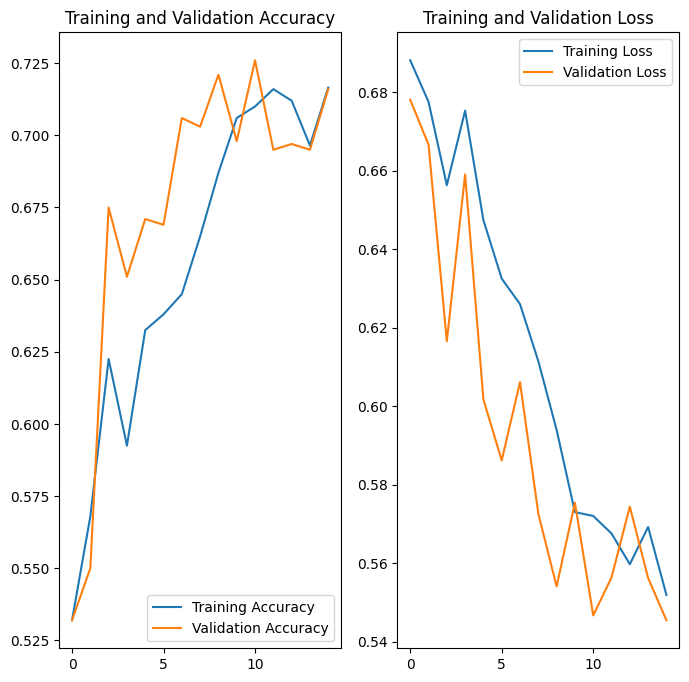

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [33]:
predictions = model.predict(test_data_gen)
probabilities = [1 if a[0]<a[1] else 0 for a in predictions]
# probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


In [34]:
print(len(probabilities))

50


In [35]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers))

passed_challenge = percentage_identified > 0.63

print(f"Your model correctly identified {round(percentage_identified*100, 2)}%"
      f"of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0%of the images of cats and dogs.
You passed the challenge!
